# Step-by-step example of JDFLOW.
## Kirill Zakharov
2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div, factorial
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
from scipy.optimize import minimize
import scipy.stats as sts
from tqdm import tqdm
import itertools


from JDFLOW.intensity_optimization import *
from JDFLOW.signature_computation import *
from JDFLOW.stochastic_processes import *
from JDFLOW.nsde_functions import *
from JDFLOW.nsde_solvers import *
from JDFLOW.jdflow import *
from JDFLOW.evaluate.metrics import *
from JDFLOW.FourierFlows import FourierFlow
from JDFLOW.FSDE import train_fsde
from JDFLOW.evaluate.metrics import *
from Model import inverse_preprocessing

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [2]:
# data = pd.read_csv('Data/gen.us.txt')['Close'].values
# data2 = pd.read_csv('Data/amzn.us.txt')['Close'].values

In [3]:
# plt.plot(data)
# # plt.plot(data2)

# plt.show()

In [4]:
# data = np.log1p(data)
# data2 = np.log1p(data2)

# scaler = MinMaxScaler((0, 1))

# data = scaler.fit_transform(data.reshape(-1, 1)).T[0]
# data2 = scaler.fit_transform(data2.reshape(-1, 1)).T[0]
# data2 = data2[:len(data)]

In [5]:
# plt.plot(data)
# plt.plot(data2)
# plt.show()

In [6]:
# data_tensor = torch.FloatTensor(np.vstack([data, data2]))
# data0 = data_tensor[0]

In [7]:
# def create_setA(data: np.array) -> torch.Tensor:
#     set_A = torch.zeros(len(data), len(data))
#     k = 1
#     for i in range(len(data)):
#         set_A[i, :k] = torch.FloatTensor(data[:k])
#         k += 1
    
#     return set_A

In [8]:
# set_A = torch.stack(list(map(lambda x: create_setA(x), data)))

In [9]:
# np.linalg.eig(np.matmul(set_A[0], np.transpose(set_A[0])))[0]

In [10]:
# set_A = create_setA(data)

## Data Preparation

In [2]:
n = 300 #set the series length
dt = 1/n

#choose any of type process or upload your data. The main rule that length of each series must be the same.
# data = dclProcess(n, 10).T
data = np.array([merton_process(s0=1, xiP=3, muj=0, sigmaj=0.2, r=0.04, sigma=0.6, n=n, T=1) for i in range(5)])
# data = np.array([geometric_BM(s0=1, mu=0.1, sigma=0.5, n=n, T=1) for i in range(10)])

In [3]:
# np.save('Data/Merton_jump_diffusion.npy', data)

In [4]:
# data = np.load('Data/Merton_jump_diffusion.npy')

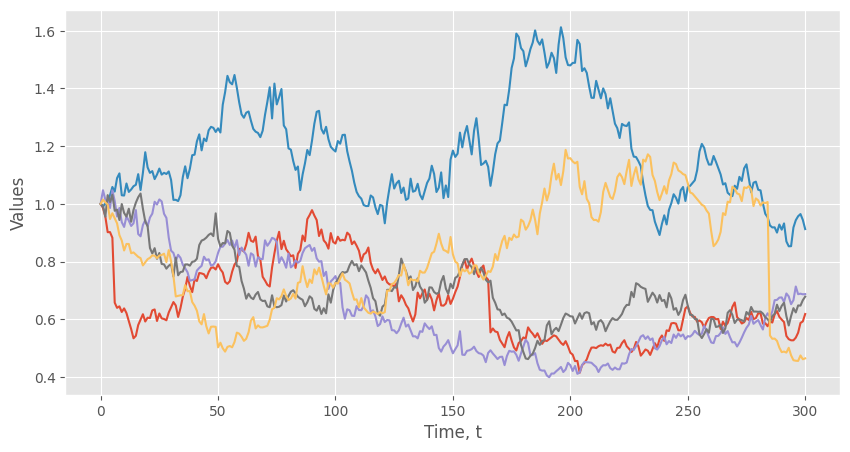

In [5]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(data.T)

plt.xlabel('Time, t')
plt.ylabel('Values')
plt.show()

Save initial data

In [6]:
data_save = copy.deepcopy(torch.FloatTensor(data))

Preprocess the data

In [7]:
scaler = MinMaxScaler((0, 1))
data = scaler.fit_transform(data.T).T

In [8]:
data_tensor = torch.FloatTensor(data)
data0 = data_tensor[0]

## Identify jump intensity

Choose the $\lambda_j$ to identify the initial jump intensity in the whole data set.

In [11]:
lambda_j = 0.1
idx_jumps = list(map(lambda x: find_jumps(x, lambda_j), data_save))

Black points show the jump positions in the inital data.

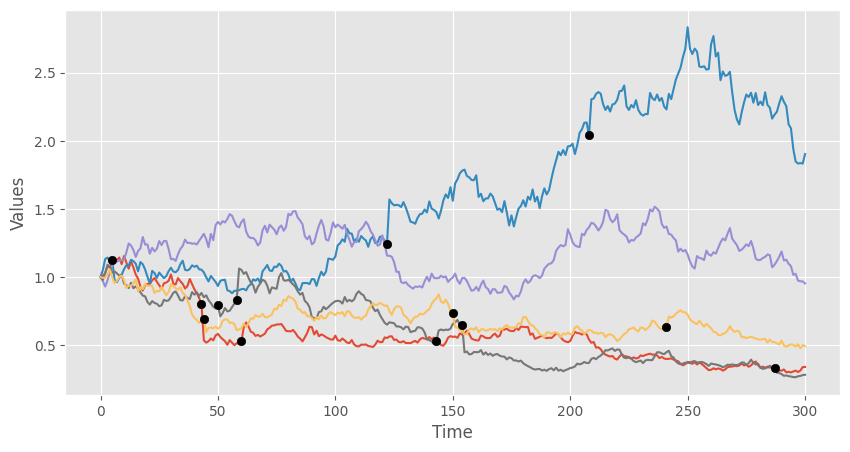

In [12]:
plot_jumps(data_save, idx_jumps)

Initial intensity

In [13]:
init_intensity = estimate_init_intensity_array(data_save, idx_jumps)/dt
init_intensity

array([1.99335548, 2.99003322, 0.        , 4.9833887 , 2.99003322])

Initital parameters

In [14]:
jump_part, diff_part = separate_dynamics(data_save, idx_jumps)
init_params = estimate_init_params(data_save, jump_part, diff_part, dt)

Maximize likelihood

In [15]:
opt_params = optimize_params(data_save, init_params, init_intensity, dt)

In [16]:
xiP0 = opt_params[-1]
xiP0

2.591362126245847

## Signature Examples

In [17]:
signature_traj = compute_path_signature_torch(data_save, level_threshold=3)
signature = signature_set(signature_traj)[1:]

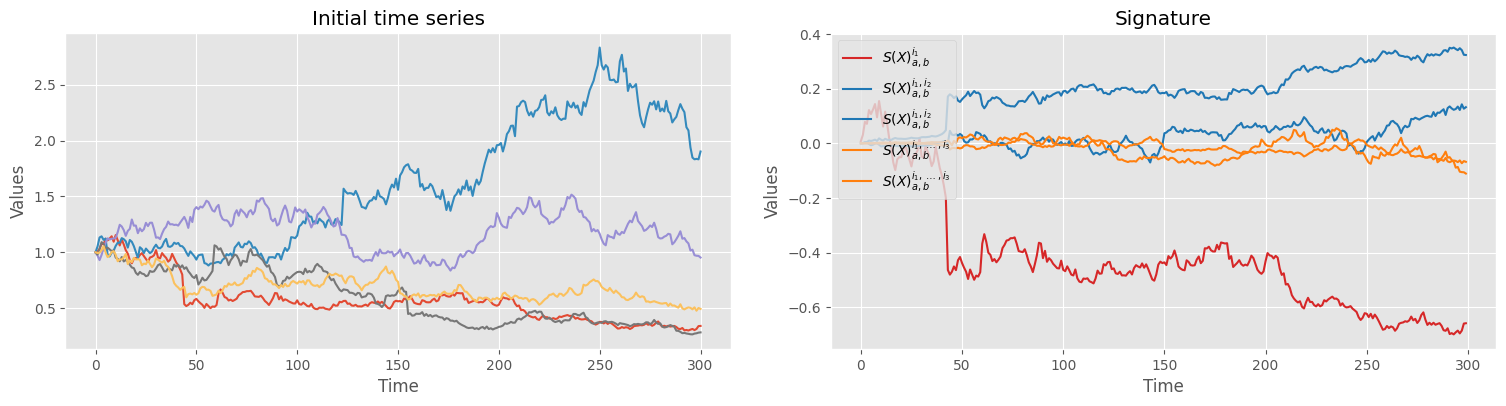

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(data_save.T)
axs[0].set_title('Initial time series')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(signature_traj[1][0], color='tab:red', label='$S(X)_{a,b}^{i_1}$')
axs[1].plot(signature_traj[2][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[2][4], color='tab:blue', label='$S(X)_{a,b}^{i_1,i_2}$')
axs[1].plot(signature_traj[3][2], color='tab:orange', label='$S(X)_{a,b}^{i_1,\dots,i_3}$')
axs[1].plot(signature_traj[3][4], color='tab:orange', label='$S(X)_{a,b}^{i_1,\dots,i_3}$')
# plt.plot(signature_traj[9][0], color='tab:blue', label='$S(X)_{a,b}^{i_1,\dots,i_9}$')
axs[1].legend(fontsize=10, loc=2)
axs[1].set_title('Signature')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.15)
# plt.savefig('Signature_ex4.pdf', dpi=300)
plt.show()

## Train model

In [19]:
# class DiffMap(nn.Module):
#     def __init__(self, time_steps, h_dim, M, dt, permute):
#         super(DiffMap, self).__init__()
    
#         self.h_dim = h_dim
#         self.laten_dim = M
#         self.time_steps = time_steps
#         self.dt = dt

#         hidden = 2**7
#         self.v_dim = M
#         self.d = h_dim // 2
#         self.r = M // 2
#         self.permute = permute
        
#         self.in_size = self.d
#         self.out_size = self.h_dim - self.d

    
#         if self.permute:
#             self.in_size, self.out_size = self.out_size, self.in_size

        
#         self.fc_mu = nn.Sequential(
#             # nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
#             # extract_tensor(),
#             # nn.Sigmoid(),
#             nn.Linear(self.in_size, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, self.out_size)
#         )
#         self.fc_sig = nn.Sequential(
#             nn.LSTM(self.in_size, self.in_size, num_layers=1, batch_first=True),
#             extract_tensor(),
#             nn.Sigmoid(),
#             nn.Linear(self.in_size, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, self.out_size)
#         )
#         self.nu = nn.Sequential(
#             nn.Linear(M, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, M)
#         )
   
#         self.p = nn.Sequential(
#             nn.Linear(self.time_steps, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, hidden),
#             nn.Sigmoid(),
#             nn.Linear(hidden, self.in_size)
#         )
#         self.tanh = nn.Tanh()
        
#         self.f = nn.Sequential(nn.Linear(self.in_size, hidden),
#                                nn.Sigmoid(),
#                                nn.Linear(hidden, self.out_size))
        
#         self.base_dist = MultivariateNormal(torch.zeros(h_dim), torch.eye(h_dim))

#     def forward(self, x, vt):
#         x1, x2 = x[:, :self.d], x[:, self.d:]
    
#         if self.permute:
#             x2, x1 = x1, x2
        
#         p_hat = self.tanh(self.p(vt.T))
#         z1 = x1 + p_hat
#         sig = self.fc_sig(z1)
#         z2 = self.fc_mu(z1) * self.f(self.nu(z1.T).T) + x2 * torch.exp(sig)
        
#         if self.permute:
#             z2, z1 = z1, z2 
 
#         z = torch.cat([z1, z2], axis=1)
        
#         log_pz = self.base_dist.log_prob(z)
#         log_jacob = sig.sum(-1)

#         return z, log_pz, log_jacob
    
        

#     def inverse(self, z, vt):
#         z1, z2 = z[:, :self.d], z[:, self.d:]
        
#         if self.permute:
#             z2, z1 = z1, z2
            
#         x2 = (z2 - self.fc_mu(z1) * self.f(self.nu(z1.T).T)) * torch.exp(-self.fc_sig(z1))
        
#         p_hat = self.tanh(self.p(vt.T))
#         x1 = z1 - p_hat
      
#         if self.permute:
#             x2, x1 = x1, x2
        
#         x = torch.cat([x1, x2], axis=1)

#         return x



# class JDFlow(nn.Module):
#     def __init__(self, n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0):
#         super(Flow, self).__init__()
        
#         self.h_dim = h_dim
#         self.permute = [True if i % 2 else False for i in range(n_flows)]

#         self.bijections = nn.ModuleList(
#             [DiffMap(time_steps, h_dim, M, dt, self.permute[i]) for i in range(n_flows)]
#         )
        
#         self.xiP = xiP0
        
#         self.time_steps = time_steps
#         self.dt = dt
#         self.v_dim = M
#         self.psi = Operator_F(self.time_steps, self.h_dim)
#         self.zeta = Operator_F(self.h_dim, self.h_dim)
        
#         self.drift = Drift(self.v_dim)
#         self.diffusion = Diffusion(self.v_dim, 1)
#         self.jump = Jump(self.v_dim)
#         self.phi = Phi(self.v_dim, M, M)
#         self.sigmoid_sig = nn.Sigmoid()

#     def forward(self, x):
#         log_jacobs = []
        
#         wt = torch.randn((1, self.v_dim))
#         v0 = self.phi(wt, x[:, 0].view(1, x.size(0)))
#         self.vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)
        
#         self.non_linearity = torch.exp(-self.psi(self.vt.T))
#         x = self.non_linearity * x + self.zeta(self.non_linearity)
        

#         for bijection in self.bijections:
#             x, log_pz, lj = bijection(x, self.vt)

#             log_jacobs.append(lj)

#         return x, log_pz, sum(log_jacobs)

#     def inverse(self, z):
        
#         # wt = torch.randn((1, self.v_dim))
#         # v0 = self.phi(wt, z[:, 0].view(1, z.size(0)))
#         # vt = sdeint_jump(self.drift, self.diffusion, self.jump, self.dt, v0, self.time_steps, self.v_dim, self.xiP)

#         for bijection in reversed(self.bijections):
#             z = bijection.inverse(z, self.vt)
            
#         self.non_linearity = torch.exp(-self.psi(self.vt.T))
#         z = (z - self.zeta(self.non_linearity)) / self.non_linearity


#         return z
    
#     def fit(self, X, epochs=1000, learning_rate=1e-3):
#         optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
#         scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[400], gamma=0.3)
       
#         losses = []
#         mse = nn.MSELoss()
#         epochs = tqdm(range(epochs))

#         for _ in epochs:
#             _, log_pz, log_jacob = self.forward(X)
            
#             # p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
#             # z = p_Z.rsample(sample_shape=(X.size(0),))
#             # synth_x = self.inverse(z)
            
#             # signature = (stack_signatures(compute_path_signature_torch(synth_x, level_threshold=2)[1:]))
#             # signature_true = (stack_signatures(compute_path_signature_torch(X, level_threshold=2)[1:]))
            
#             loss_likelihood = (-log_pz - log_jacob).mean() 
          
#             # loss_sig = mse(signature, signature_true)
#             # loss_init_values = torch.mean((X[:, 0] - synth_x[:, 0])**2)
#             loss_sig = loss_likelihood
#             loss_init_values = loss_likelihood
            
#             total_norm = 0.0
#             for p in self.parameters():
#                 param_norm = p.norm(2)
#                 total_norm += param_norm.item() ** 2
#                 total_norm = total_norm ** (1. / 2)
        
#             loss = loss_likelihood + total_norm 
#             # + 0.01 * loss_sig + loss_init_values + total_norm
            

#             optim.zero_grad()
#             loss.backward()
#             optim.step()
#             scheduler.step()

#             epochs.set_description(f'Loss: {round(loss.item(), 4)}')
#             losses.append([loss_likelihood.item(), loss_init_values.item(), loss_sig.item()])
            
#         return np.array(losses)
            
    
#     def sample(self, n_samples):
#         samples_array = []
            
#         if n_samples % self.v_dim == 0:
#             for i in range(n_samples // self.v_dim):
#                 p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
#                 z = p_Z.rsample(sample_shape=(self.v_dim,))

#                 X_sample = self.inverse(z).detach().numpy()
#                 samples_array.append(X_sample)
                
#             samples_array = np.vstack(samples_array)
                
#         else:
#             for i in range(n_samples // self.v_dim + 1):
#                 p_Z = MultivariateNormal(torch.zeros(self.h_dim), torch.eye(self.h_dim))
#                 z = p_Z.rsample(sample_shape=(self.v_dim,))

#                 X_sample = self.inverse(z).detach().numpy()
#                 samples_array.append(X_sample)
              
#             samples_array = np.vstack(samples_array)[:n_samples]

#         return samples_array

In [20]:
# data_tensor = data_tensor.view(1, -1) #if use only one series

In [9]:
h_dim = len(data_tensor[0])
M = data_tensor.size(0)
time_steps = 100
dt = torch.FloatTensor([1/time_steps])
# n = data_tensor.size(0)
sig_dim = n + n**2 

In [23]:
# nsde_flow = Flow(128, 10, h_dim, h_dim)
n_flows = 10

nsde_flow = JDFlow(n_flows, h_dim, M, time_steps, dt, sig_dim, xiP0)

losses = nsde_flow.fit(data_tensor, epochs=1000)

Loss: -1474.1738: 100%|██████████| 1000/1000 [01:44<00:00,  9.53it/s]


In [24]:
nsde_flow.eval()

Flow(
  (bijections): ModuleList(
    (0): DiffMap(
      (fc_mu): Sequential(
        (0): Linear(in_features=150, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=151, bias=True)
      )
      (fc_sig): Sequential(
        (0): LSTM(150, 150, batch_first=True)
        (1): extract_tensor()
        (2): Sigmoid()
        (3): Linear(in_features=150, out_features=128, bias=True)
        (4): Sigmoid()
        (5): Linear(in_features=128, out_features=128, bias=True)
        (6): Sigmoid()
        (7): Linear(in_features=128, out_features=151, bias=True)
      )
      (nu): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=5, bias=True)
      )
      (p): Sequent

In [25]:
samples = nsde_flow.sample(5)
# samples = samples[(~(np.max(samples, axis=1) > 1.5*np.max(data))) & (~(np.min(samples, axis=1) < 1.5*np.min(data)))]

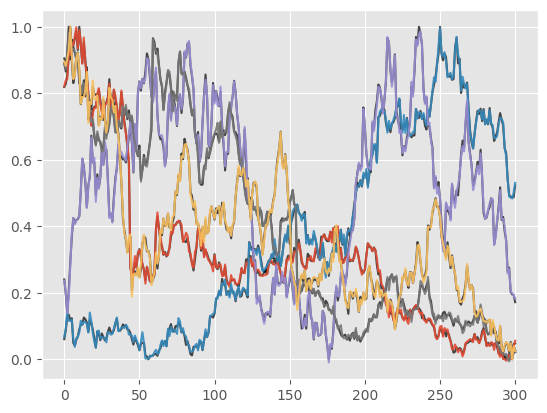

In [26]:
plt.plot(data_tensor.T, color='black', alpha=0.7, label='Real')
plt.plot(samples[:, :].T, alpha=0.9, label='Synth')

# plt.legend()
plt.show()

In [12]:
# def inverse_preprocessing(samples):
#     synth_data = []

#     if samples.shape[0] % M == 0:
#         for i in range(samples.shape[0] // M):
#             synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
            
#     else:
#         for i in range(samples.shape[0] // M):
#             synth_data.append(scaler.inverse_transform(samples[M*i:M*(i+1)].T).T)
            
#         last = samples.shape[0] % M
#         synth_data.append(scaler.inverse_transform(np.vstack([samples[-last:], np.ones((M - last, samples.shape[1]))]).T).T[:last])
        
#     synth_data = np.vstack(synth_data)
    
#     return synth_data

In [28]:
synth_data = inverse_preprocessing(samples, M, scaler)
real_data = scaler.inverse_transform(data.T, M, scaler).T

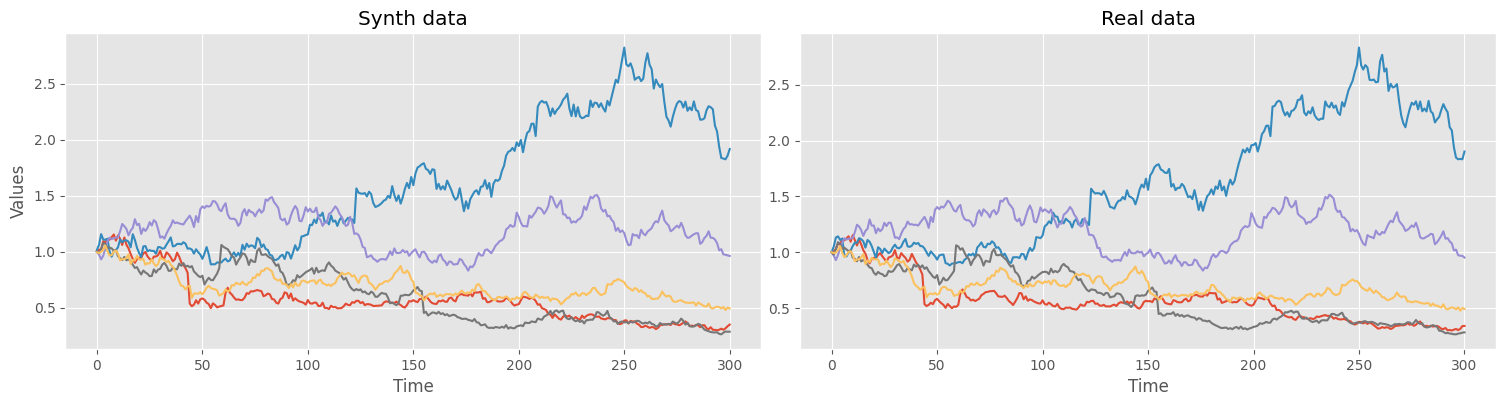

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_data[:].T)
axs[0].set_title('Synth data')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(real_data[:].T)
axs[1].set_title('Real data')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_many_synth2.pdf', dpi=300)
plt.show()

In [10]:
# def plotCollection(ax, ys, *args, **kwargs):

#   ax.plot(ys, *args, **kwargs)

#   if "label" in kwargs.keys():

#     #remove duplicates
#     handles, labels = plt.gca().get_legend_handles_labels()
#     newLabels, newHandles = [], []
#     for handle, label in zip(handles, labels):
#       if label not in newLabels:
#         newLabels.append(label)
#         newHandles.append(handle)

#     plt.legend(newHandles, newLabels)

# _, ax = plt.subplots(figsize=(10, 5), dpi=100)
# plotCollection(ax, real_data[:3].T, linestyle='--', color='black', label='Real')
# plotCollection(ax, synth_data[:3].T, label='Synth')

# plt.ylabel('Values')
# plt.xlabel('Time')
# plt.tight_layout(pad=0.5)
# # plt.savefig('Merton_3_plots.pdf', dpi=300)
# plt.show()

In [31]:
# fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# axs[0].plot(losses.T[0])
# axs[0].set_title('Likelihood loss')

# axs[1].plot(losses.T[1])
# axs[1].set_title('Init values loss')

# axs[2].plot(losses.T[2])
# axs[2].set_title('Signature loss')

# plt.subplots_adjust(hspace=0.4)
# plt.show()

### Fourier Flows

In [32]:
data_tensor = data_tensor[:, :(len(data_tensor[0]) // 4 * 4 + 1 if len(data_tensor[0]) % 4 > 0 else len(data_tensor[0]) - 3)]

In [33]:
fourier_flow = FourierFlow(2**8, len(data_tensor[0]), 10, FFT=True, flip=True, normalize=False)

fourier_flow.fit(data_tensor, epochs=1000)
samples_ff = fourier_flow.sample(5)

Loss: -2443.555908203125: 100%|██████████| 1000/1000 [00:21<00:00, 46.94it/s]


In [34]:
rnvp_flow = FourierFlow(2**8, len(data_tensor[0]), 10, FFT=False, flip=True, normalize=False)

rnvp_flow.fit(data_tensor, epochs=1000)
samples_rnvp = rnvp_flow.sample(5)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss: -968.7322387695312: 100%|██████████| 1000/1000 [00:20<00:00, 48.38it/s]


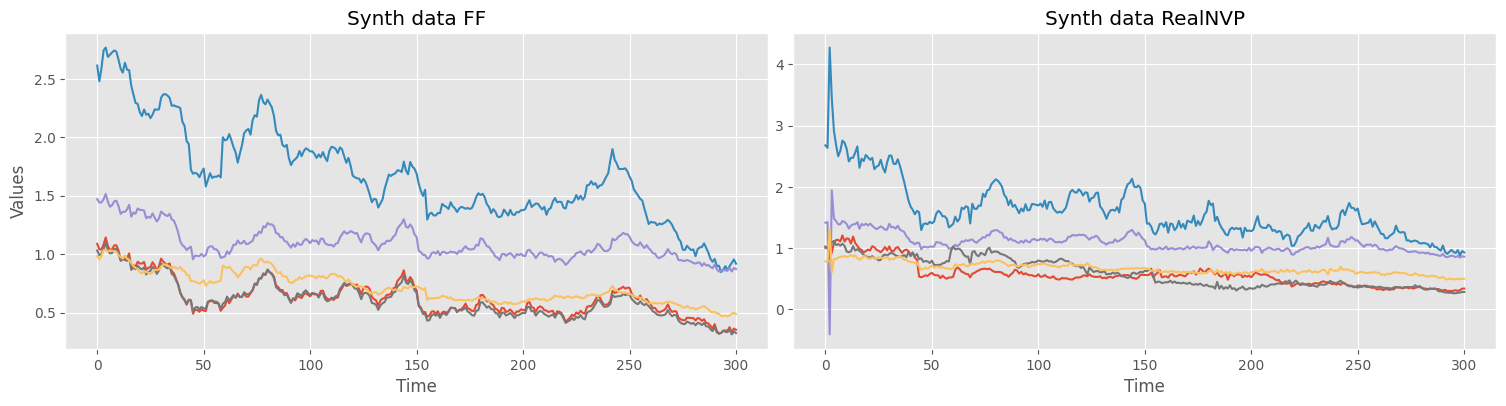

In [36]:
synth_ff = inverse_preprocessing(samples_ff, M, scaler)
synth_rnvp = inverse_preprocessing(samples_rnvp, M, scaler)

fig, axs = plt.subplots(1, 2, figsize=(15, 4), dpi=100)

axs[0].plot(synth_ff.T)
axs[0].set_title('Synth data FF')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Values')

axs[1].plot(synth_rnvp.T)
axs[1].set_title('Synth data RealNVP')
axs[1].set_xlabel('Time')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FF.pdf', dpi=300)
plt.show()

Iter: 100, Log Likelihood: 0.5863, Regularization: 134.1971
Iter: 100, Log Likelihood: 1.0096, Regularization: 136.7552
Iter: 100, Log Likelihood: 1.3452, Regularization: 135.6902
Iter: 100, Log Likelihood: 1.1055, Regularization: 136.0460
Iter: 100, Log Likelihood: 1.0105, Regularization: 137.1159


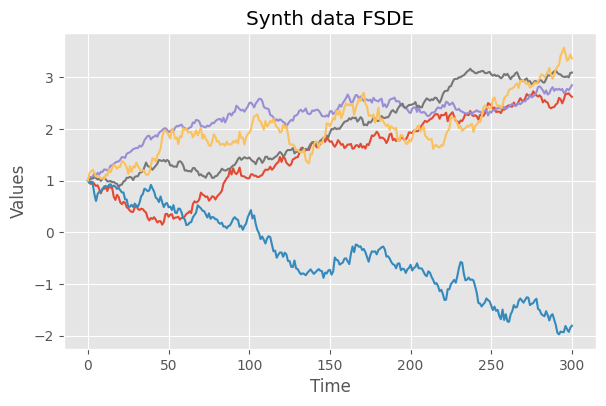

In [20]:
samples_fsde = []
for i in data_tensor:
    samples_fsde.append(train_fsde(i.view(-1, 1), method='RNN', epochs=100))
    
samples_fsde = np.array(samples_fsde)[:, 0]

synth_fsde = inverse_preprocessing(samples_fsde, M, scaler)

plt.subplots(figsize=(6, 4), dpi=100)

plt.plot(synth_fsde.T)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Synth data FSDE')

plt.tight_layout(pad=0.5)
# plt.savefig('Merton_synth_FSDE.pdf', dpi=300)
plt.show()

In [38]:
# plt.plot(data.T, color='black', alpha=0.7)
# plt.plot(synth_ff.T, alpha=0.7)
# plt.show()

### TimeGAN

In [39]:
# from JDFLOW.timeGAN import timeGAN_train

# samples_timeGAN, pca_timeGAN = timeGAN_train(data, M, 2000)
# samples_timeGAN = samples_timeGAN.T

In [40]:
# synth_timeGAN = inverse_preprocessing(samples_timeGAN, M, scaler)

In [41]:
# plt.plot(data.T, color='black', alpha=0.7)
# plt.plot(synth_timeGAN.T, alpha=0.7)
# plt.show()

### PAR from SDV

In [42]:
from sdv.sequential import PARSynthesizer
from sdv.metadata import SingleTableMetadata

df_ctgan = pd.DataFrame(data.T, columns=[f'{i}' for i in range(5)])
df_ctgan['date'] = pd.to_datetime(pd.date_range(start='2018-01-01', periods=len(data[0])), format='%Y-%m-%d')
df_ctgan['id'] = ['AAA']*len(data[0])

metadata = SingleTableMetadata()

for i in range(5):
    metadata.add_column(
        column_name=f'{i}',
        sdtype='numerical')
    
metadata.add_column(
    column_name='date',
    sdtype='datetime',
    datetime_format='%Y-%m-%d')

metadata.add_column(
    column_name='id',
    sdtype='id')

metadata.set_sequence_index(column_name='date')
metadata.set_sequence_key(column_name='id')

In [46]:
par = PARSynthesizer(metadata=metadata, epochs=500, verbose=True)
par.fit(df_ctgan)

samples_PAR = par.sample(num_sequences=1)
samples_PAR = samples_PAR.iloc[:, :M].values.T

Epoch 500 | Loss -319.7460021972656: 100%|██████████| 500/500 [00:17<00:00, 27.89it/s] 
100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


In [47]:
synth_PAR = inverse_preprocessing(samples_PAR, M, scaler)

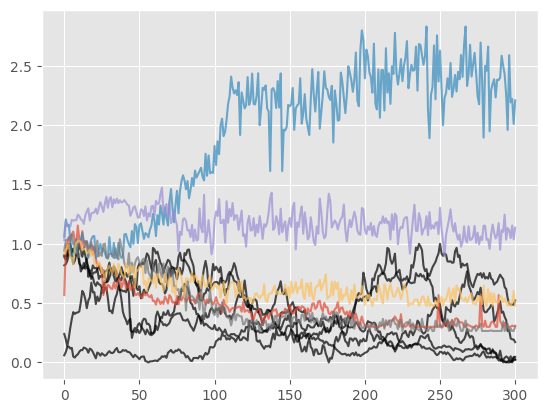

In [48]:
plt.plot(data.T, color='black', alpha=0.7)
plt.plot(synth_PAR.T, alpha=0.7)
plt.show()

## Evaluate

### Signtature distribution

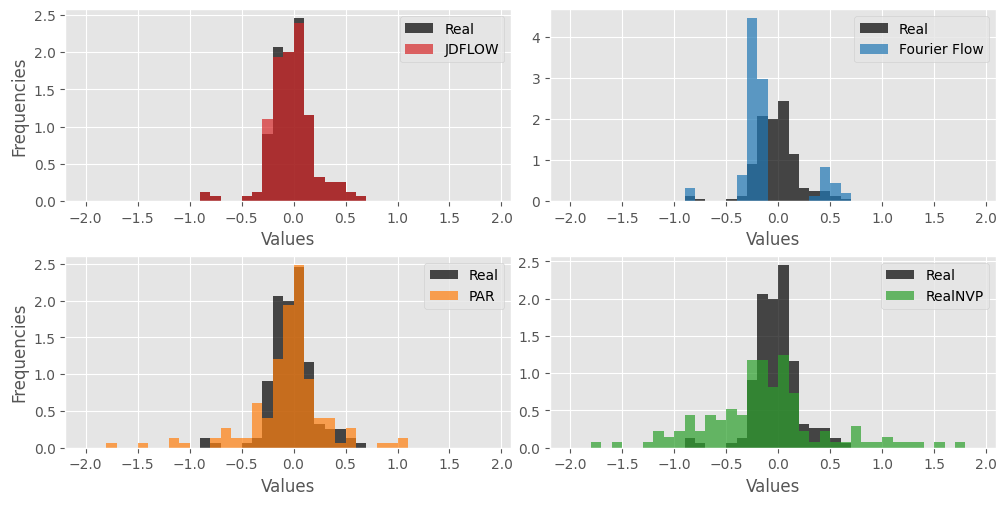

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples), level_threshold=3)
signature = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(data_tensor, level_threshold=3)
signature_real = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_ff), level_threshold=3)
signature_ff = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_PAR), level_threshold=3)
signature_PAR = signature_set(signature_traj)[1:]

signature_traj = compute_path_signature_torch(torch.FloatTensor(samples_rnvp), level_threshold=3)
signature_timeGAN = signature_set(signature_traj)[1:]



axs[0, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
axs[0, 0].hist(signature, bins=np.arange(-2, 2, 0.1), label='JDFLOW', color='tab:red', alpha=0.7, density=True)
axs[0, 0].set_xlabel('Values')
axs[0, 0].set_ylabel('Frequencies')
axs[0, 0].legend()


axs[0, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
axs[0, 1].hist(signature_ff, bins=np.arange(-2, 2, 0.1), label='Fourier Flow', color='tab:blue', alpha=0.7, density=True)
axs[0, 1].set_xlabel('Values')
# axs[0, 1].set_ylabel('Frequencies')
axs[0, 1].legend()


axs[1, 0].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
axs[1, 0].hist(signature_PAR, bins=np.arange(-2, 2, 0.1), label='PAR', color='tab:orange', alpha=0.7, density=True)
axs[1, 0].set_xlabel('Values')
axs[1, 0].set_ylabel('Frequencies')
axs[1, 0].legend()


axs[1, 1].hist(signature_real, bins=np.arange(-2, 2, 0.1), label='Real', color='black', alpha=0.7, density=True)
axs[1, 1].hist(signature_timeGAN, bins=np.arange(-2, 2, 0.1), label='RealNVP', color='tab:green', alpha=0.7, density=True)
axs[1, 1].set_xlabel('Values')
# axs[0, 0].set_ylabel('Frequencies')
axs[1, 1].legend()

plt.subplots_adjust(wspace=0.3)
plt.tight_layout(pad=0.5)
# plt.savefig(f'Signature_DCL.pdf', dpi=300) #save figure
plt.show()

### Local extrema QQ-plot

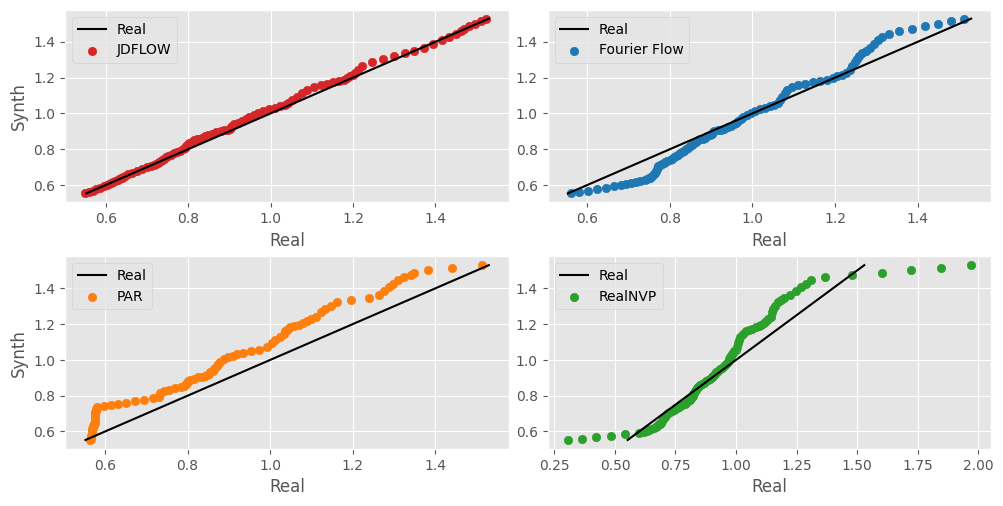

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

# plt.plot(np.arange(2), label='Real', color='black')

axs[0, 0].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[0, 0].scatter(extr_quant_computation(synth_data), extr_quant_computation(real_data), color='tab:red', label='JDFLOW')
axs[0, 0].set_xlabel('Real')
axs[0, 0].set_ylabel('Synth')
axs[0, 0].legend()


axs[0, 1].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[0, 1].scatter(extr_quant_computation(synth_ff), extr_quant_computation(real_data), color='tab:blue', label='Fourier Flow')
axs[0, 1].set_xlabel('Real')
# axs[0, 1].set_ylabel('Synth')
axs[0, 1].legend()


axs[1, 0].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[1, 0].scatter(extr_quant_computation(synth_PAR), extr_quant_computation(real_data), color='tab:orange', label='PAR')
axs[1, 0].set_xlabel('Real')
axs[1, 0].set_ylabel('Synth')
axs[1, 0].legend()


axs[1, 1].plot(extr_quant_computation(real_data), extr_quant_computation(real_data), color='black', label='Real')
axs[1, 1].scatter(extr_quant_computation(synth_rnvp), extr_quant_computation(real_data), color='tab:green', label='RealNVP')
axs[1, 1].set_xlabel('Real')
# axs[1, 1].set_ylabel('Synth')
axs[1, 1].legend()


plt.tight_layout(pad=0.5)
# plt.savefig(f'Extrema_DCL.pdf', dpi=300) #save figure
plt.show()

### Autocorrelation

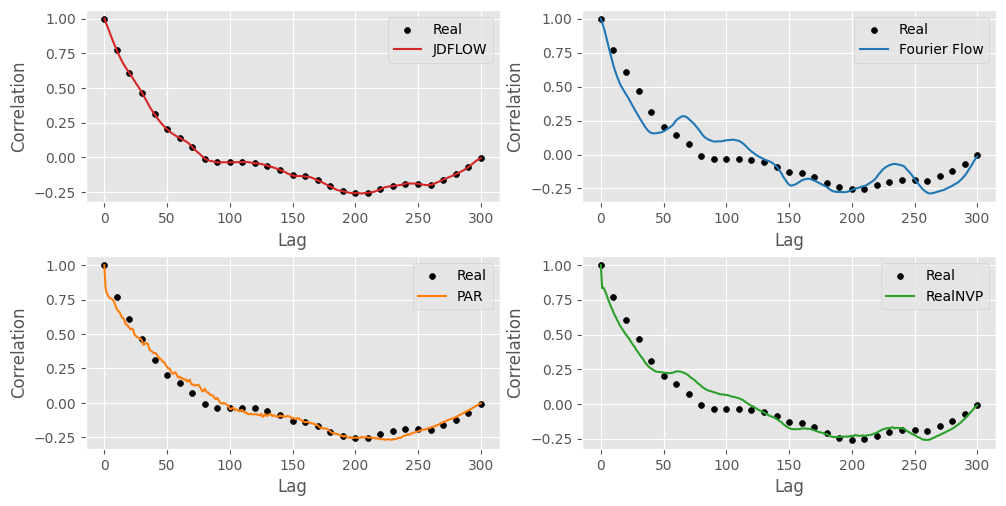

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[0, 0].plot(autocorr_vec(synth_data), label = 'JDFLOW', color='tab:red')
axs[0, 0].set_xlabel('Lag')
axs[0, 0].set_ylabel('Correlation')
axs[0, 0].legend()


axs[0, 1].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[0, 1].plot(autocorr_vec(synth_ff), label = 'Fourier Flow', color='tab:blue')
axs[0, 1].set_xlabel('Lag')
axs[0, 1].set_ylabel('Correlation')
axs[0, 1].legend()

axs[1, 0].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[1, 0].plot(autocorr_vec(synth_PAR), label = 'PAR', color='tab:orange')
axs[1, 0].set_xlabel('Lag')
axs[1, 0].set_ylabel('Correlation')
axs[1, 0].legend()

axs[1, 1].scatter(np.arange(0, len(data[0]))[::10], autocorr_vec(real_data)[::10], marker='o', label = 'Real', color='black', s=18)
axs[1, 1].plot(autocorr_vec(synth_rnvp), label = 'RealNVP', color='tab:green')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('Correlation')
axs[1, 1].legend()


plt.xticks()
plt.yticks()
plt.tight_layout(pad=0.5)
# plt.savefig(f'Autocorr_DCL.pdf', dpi=300) #save figure
plt.show()

### Numerical evaluation

In [52]:
pd.DataFrame(np.array([[w_dist_calc(real_data, real_data), w_dist_calc(real_data, synth_data),
                        w_dist_calc(real_data, synth_ff), w_dist_calc(real_data, synth_PAR), w_dist_calc(real_data, synth_rnvp)],
                       
                       [js_calc(np.abs(real_data), np.abs(real_data)), js_calc(np.abs(real_data), np.abs(synth_data)),
                        js_calc(np.abs(real_data), np.abs(synth_ff)), js_calc(np.abs(real_data), np.abs(synth_PAR)), js_calc(np.abs(real_data), np.abs(synth_rnvp))]
                       
                       ]).T, index=['Real', 'JDFLOW', 'FF', 'PAR', 'RealNVP'], columns=['W_1', 'JS'])

,W_1,JS
Real,0.000000,0.000000
JDFLOW,0.003052,0.003361
FF,0.093572,0.092264
PAR,0.128963,0.068923
RealNVP,0.063163,0.064254


### PCA

In [53]:
from sklearn.decomposition import PCA

In [69]:
pca = PCA(n_components=2)
pca_real = pca.fit_transform(data.T)
pca_jdflow = pca.fit_transform(synth_data.T)
pca_PAR = pca.fit_transform(synth_PAR.T)
pca_FF = pca.fit_transform(synth_ff.T)
pca_rnvp = pca.fit_transform(synth_rnvp.T)

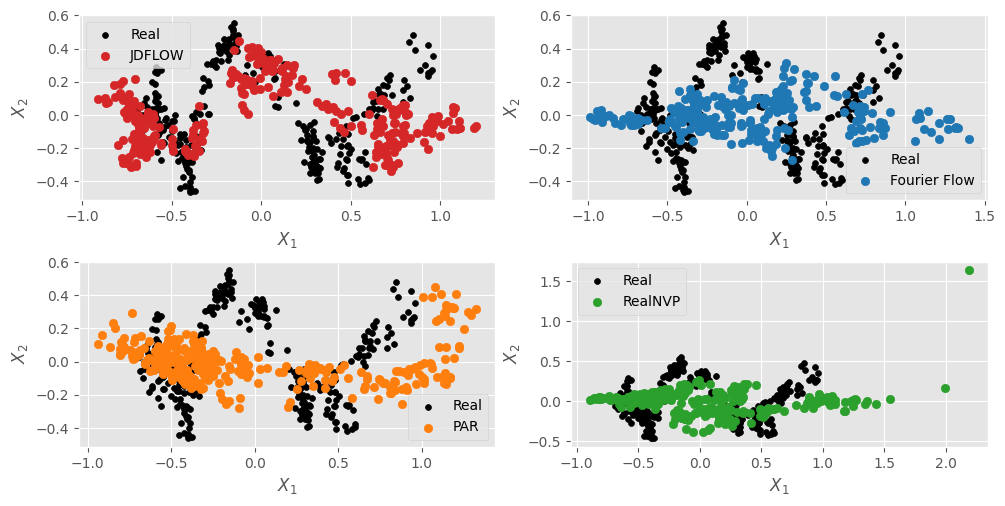

In [72]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18)
axs[0, 0].scatter(pca_jdflow[:, 0], pca_jdflow[:, 1], label = 'JDFLOW', color='tab:red')
axs[0, 0].set_xlabel('$X_1$')
axs[0, 0].set_ylabel('$X_2$')
axs[0, 0].legend()


axs[0, 1].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18)
axs[0, 1].scatter(pca_FF[:, 0], pca_FF[:, 1], label = 'Fourier Flow', color='tab:blue')
axs[0, 1].set_xlabel('$X_1$')
axs[0, 1].set_ylabel('$X_2$')
axs[0, 1].legend()

axs[1, 0].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18)
axs[1, 0].scatter(pca_PAR[:, 0], pca_PAR[:, 1], label = 'PAR', color='tab:orange')
axs[1, 0].set_xlabel('$X_1$')
axs[1, 0].set_ylabel('$X_2$')
axs[1, 0].legend()

axs[1, 1].scatter(pca_real[:, 0], pca_real[:, 1], marker='o', label = 'Real', color='black', s=18)
axs[1, 1].scatter(pca_rnvp[:, 0], pca_rnvp[:, 1], label = 'RealNVP', color='tab:green')
axs[1, 1].set_xlabel('$X_1$')
axs[1, 1].set_ylabel('$X_2$')
axs[1, 1].legend()


plt.xticks()
plt.yticks()
plt.tight_layout(pad=0.5)
# plt.savefig(f'PCA_DCL.pdf', dpi=300) #save figure
plt.show()